In [7]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise
import fig_plot as fplot
import model_fitting as fit

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dataset zipper kinase model
0     E+E    E+E     wt  push
1    RR+A   RR+A     wt  push

35841
35841


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                
E+E     0      5993.989258  6394.181152   8649.121094          1.352655
        1       484.283875   664.000793    564.378601          0.849967
        2       605.894165   737.394714     91.147232          0.123607
        3       803.416565   333.886597    168.033020          0.503264
        4      3100.157715   131.973206     60.481567          0.458287
...                    ...          ...           ...               ...
RR+A    19607  3522.244385   487.195374    112.259155          0.230419
        19608   549.186218   657.218994     95.995728          0.146064
        19609  9246.974609    55.624283     90.316620          1.623691
        19610   952.849854   376.329620     44.686310          0.118742
        19611  8025.787598  1125.326172    165.453125          0.147027

[35841 rows x 4 columns]

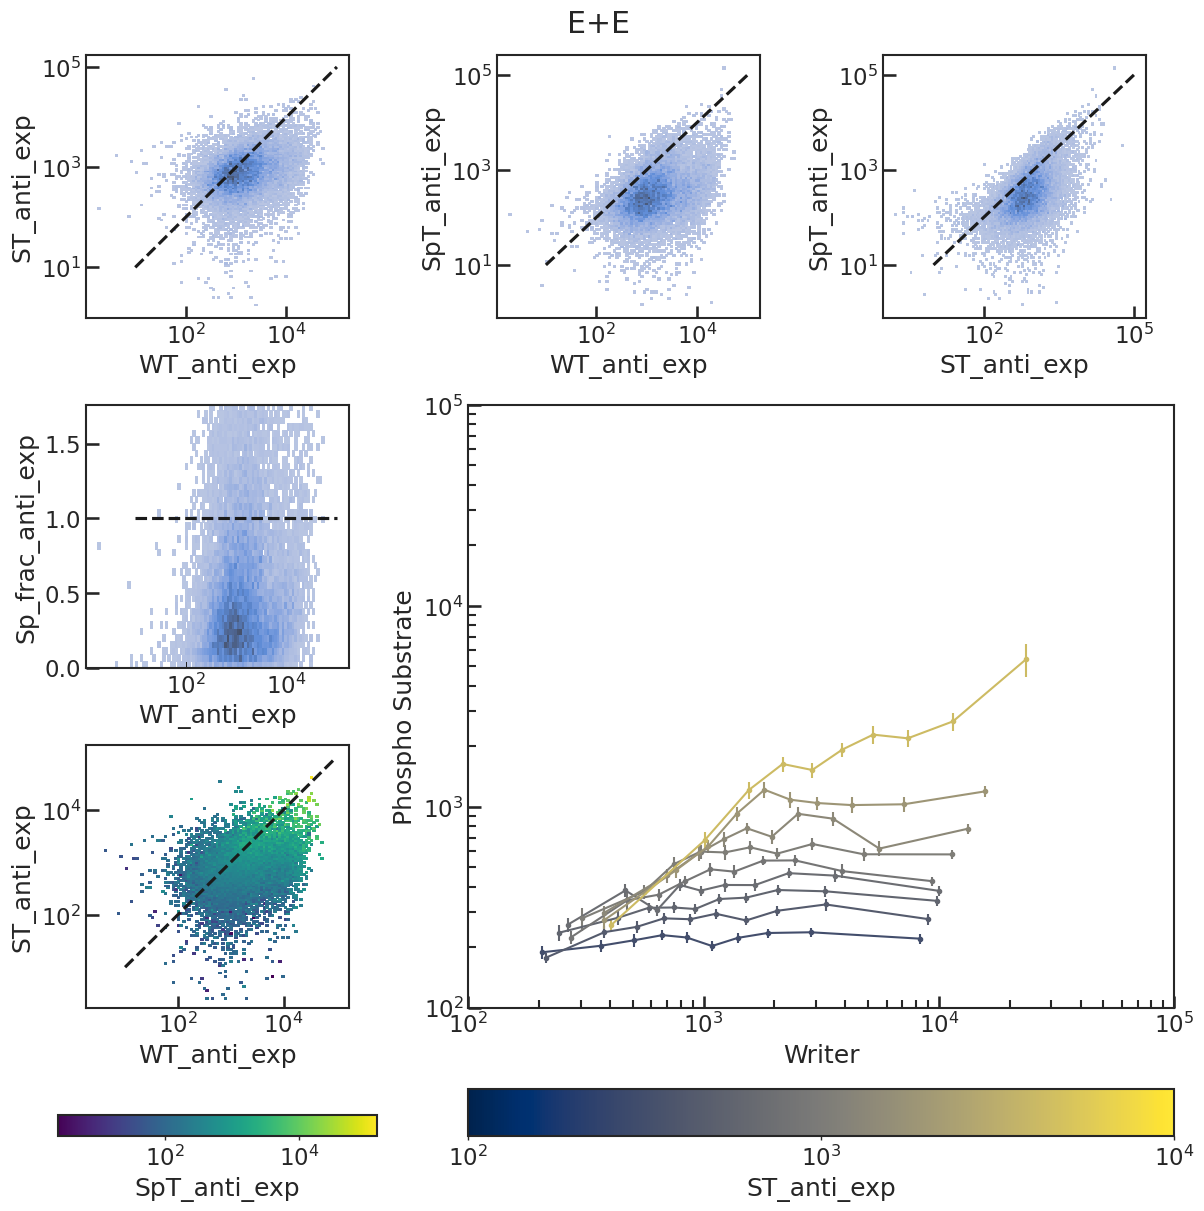

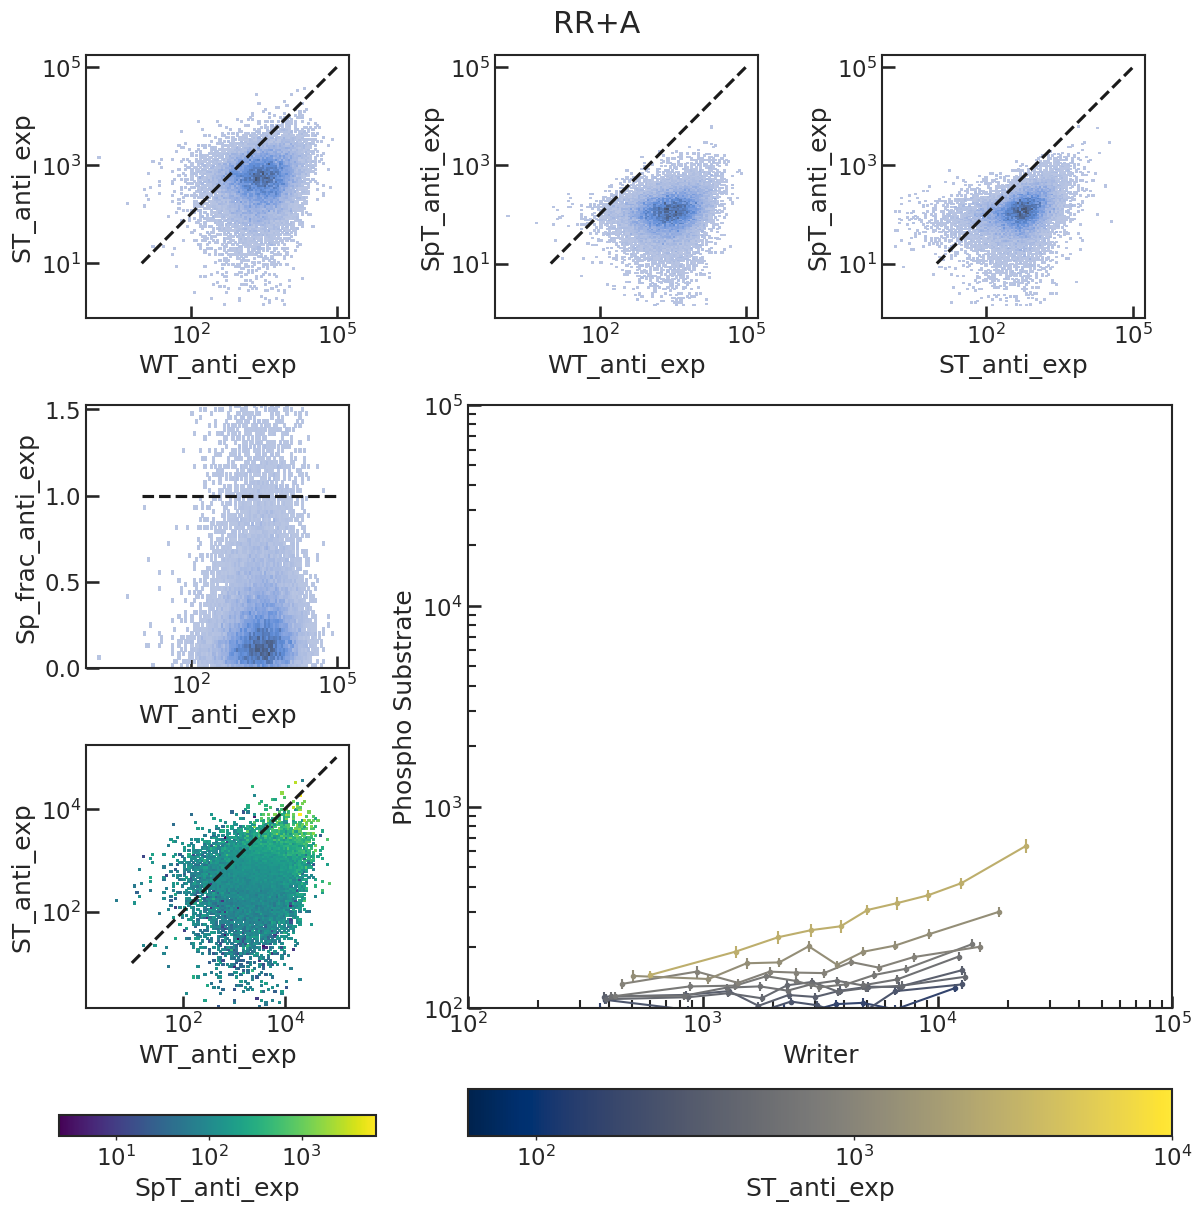

In [9]:
data_label = '210620'

# dataset, zipper variant, kinase variant, model
s_list = [
    ['E+E', 'E+E', 'wt', 'push'],
#     ['I+E', 'I+E', 'wt', 'push'],
    ['RR+A', 'RR+A', 'wt', 'push'],
#     ['S+A', 'S+A', 'wt', 'push'],
#     ['S+E', 'S+E', 'wt', 'push'],
#     ['wt', 'generic', 'wt', 'push'],
#     ['KD', 'generic', 'KD', 'push'],
#     ['R460A', 'generic', 'R460A', 'push'],
#     ['R460K', 'generic', 'R460K', 'push'],
#     ['R460S', 'generic', 'R460S', 'push'],
         ]


# data_label = '210728'

# s_list = [
#     ['L_250', 'EE_L', 'wt', 'push'],
#     ['E_250', 'EE_E', 'wt', 'push'],
#     ['RR_250', 'RR', 'wt', 'push'],
#     ['S+E_250', 'S+E', 'wt', 'push'],
#     ['375', 'generic', '375', 'push'],
#     ['419', 'generic', '419', 'push'],
#     ['421_1000', 'generic', '421', 'push']
#          ]


df_info = pd.DataFrame(s_list, columns=['dataset', 'zipper', 'kinase', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/{0}_push/{1}.csv".format(data_label, row['dataset']))    
    df['dataset'] = row['dataset']      
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


print(len(df.index))
df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'Flag : APC - Area': 'WT_anti_exp', 'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})
print(len(df.index))

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']


# df = df.query("ST_anti_exp > 1e2")

display(df)


for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()

    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    
    
    gs = fig.add_gridspec(3, 3)
    
    ax = fig.add_subplot(gs[0, 0])
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 1])
        
    sns.histplot(df_tmp, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 2])
    
    sns.histplot(df_tmp, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################

    ax = fig.add_subplot(gs[1, 0])
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, df_tmp['Sp_frac_anti_exp'].quantile(0.95))
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[2, 0])
    
#     fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp')

    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp')
    
    ##########################################################
    
    ax = fig.add_subplot(gs[1:3, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp')
    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    
    


Num Cells: 6460 Points per bin: 10 Num Bins: 25
Num Cells: 12085 Points per bin: 10 Num Bins: 34


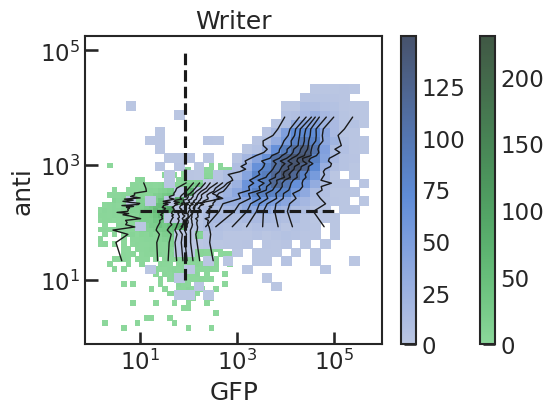

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


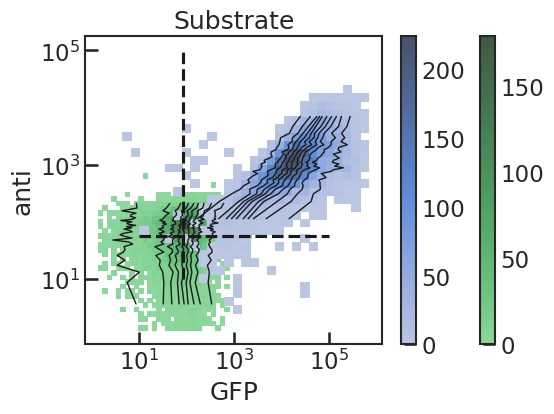

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


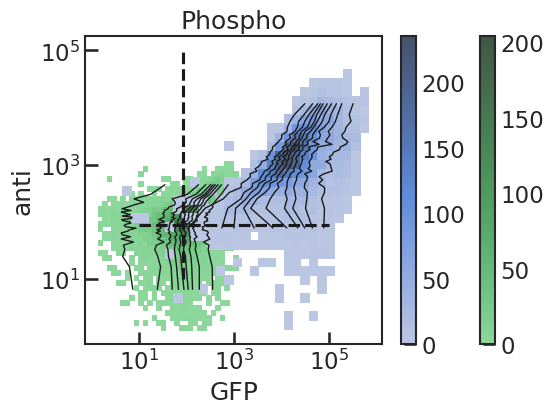

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 20554 Points per bin: 10 Num Bins: 45


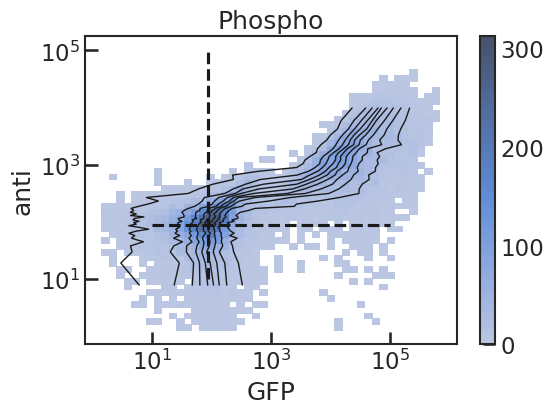

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


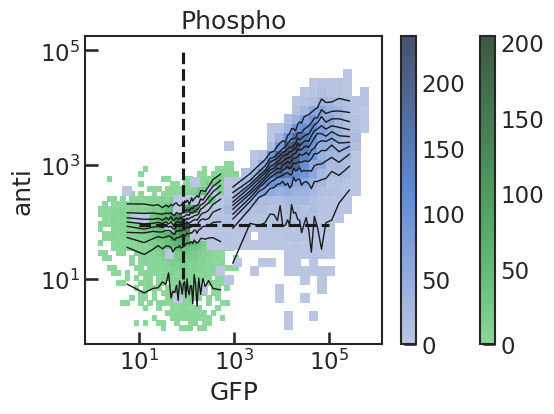

Num Cells: 20554 Points per bin: 10 Num Bins: 45


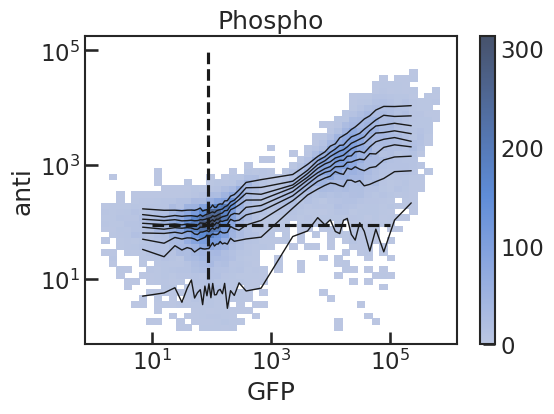

In [10]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Flag noise.csv".format(data_label), 
                                   'HA', 'GFP', ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'HA', 'GFP', ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Myc', 'GFP', ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'Myc', 'GFP', ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


combined_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)
combined_phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
combined_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



inverse_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

inverse_empty_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inverse_empty_phospho_noise.plot(ax, color='g')
inverse_phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



inverse_phospho_noise.add_cells(inverse_empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
inverse_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



14 0.06734002390989319 [0.23139764 0.48526492] 0
20 0.061318670417153553 [0.22374696 0.48526492] 0
62 0.05474040250725076 [0.01328127 0.26534235] 0
76 0.034547228056681284 [0.03619268 0.26534235] 0
608 0.03390555391104011 [0.03414502 0.26534235] 0
1216 0.0332537164905754 [0.03480985 0.26534235] 0
2539 0.03247598987467748 [0.01220653 0.2358377 ] 0
2603 0.03227646448693122 [0.01484354 0.23702721] 0
2725 0.031975354310407766 [0.01484354 0.23771348] 0
2856 0.03185448155196102 [0.01359633 0.23771348] 0
3249 0.03185448155196069 [0.01359633 0.23732837] 0
3316 0.03182758151597076 [0.01331913 0.23732837] 0
3332 0.03182750116634525 [0.0133183  0.23732837] 0
3416 0.031805937470885226 [0.01309618 0.23732837] 0
3670 0.03171398637048023 [0.02683976 0.25060261] 0
3768 0.03150612543252884 [0.02443904 0.25060261] 0
3793 0.030618911673327975 [0.02443904 0.24934249] 0
3968 0.030493766937902345 [0.02456413 0.24934249] 0
4044 0.030236896432161237 [0.02492363 0.24934249] 0
4796 0.03020535343272429 [0.024893

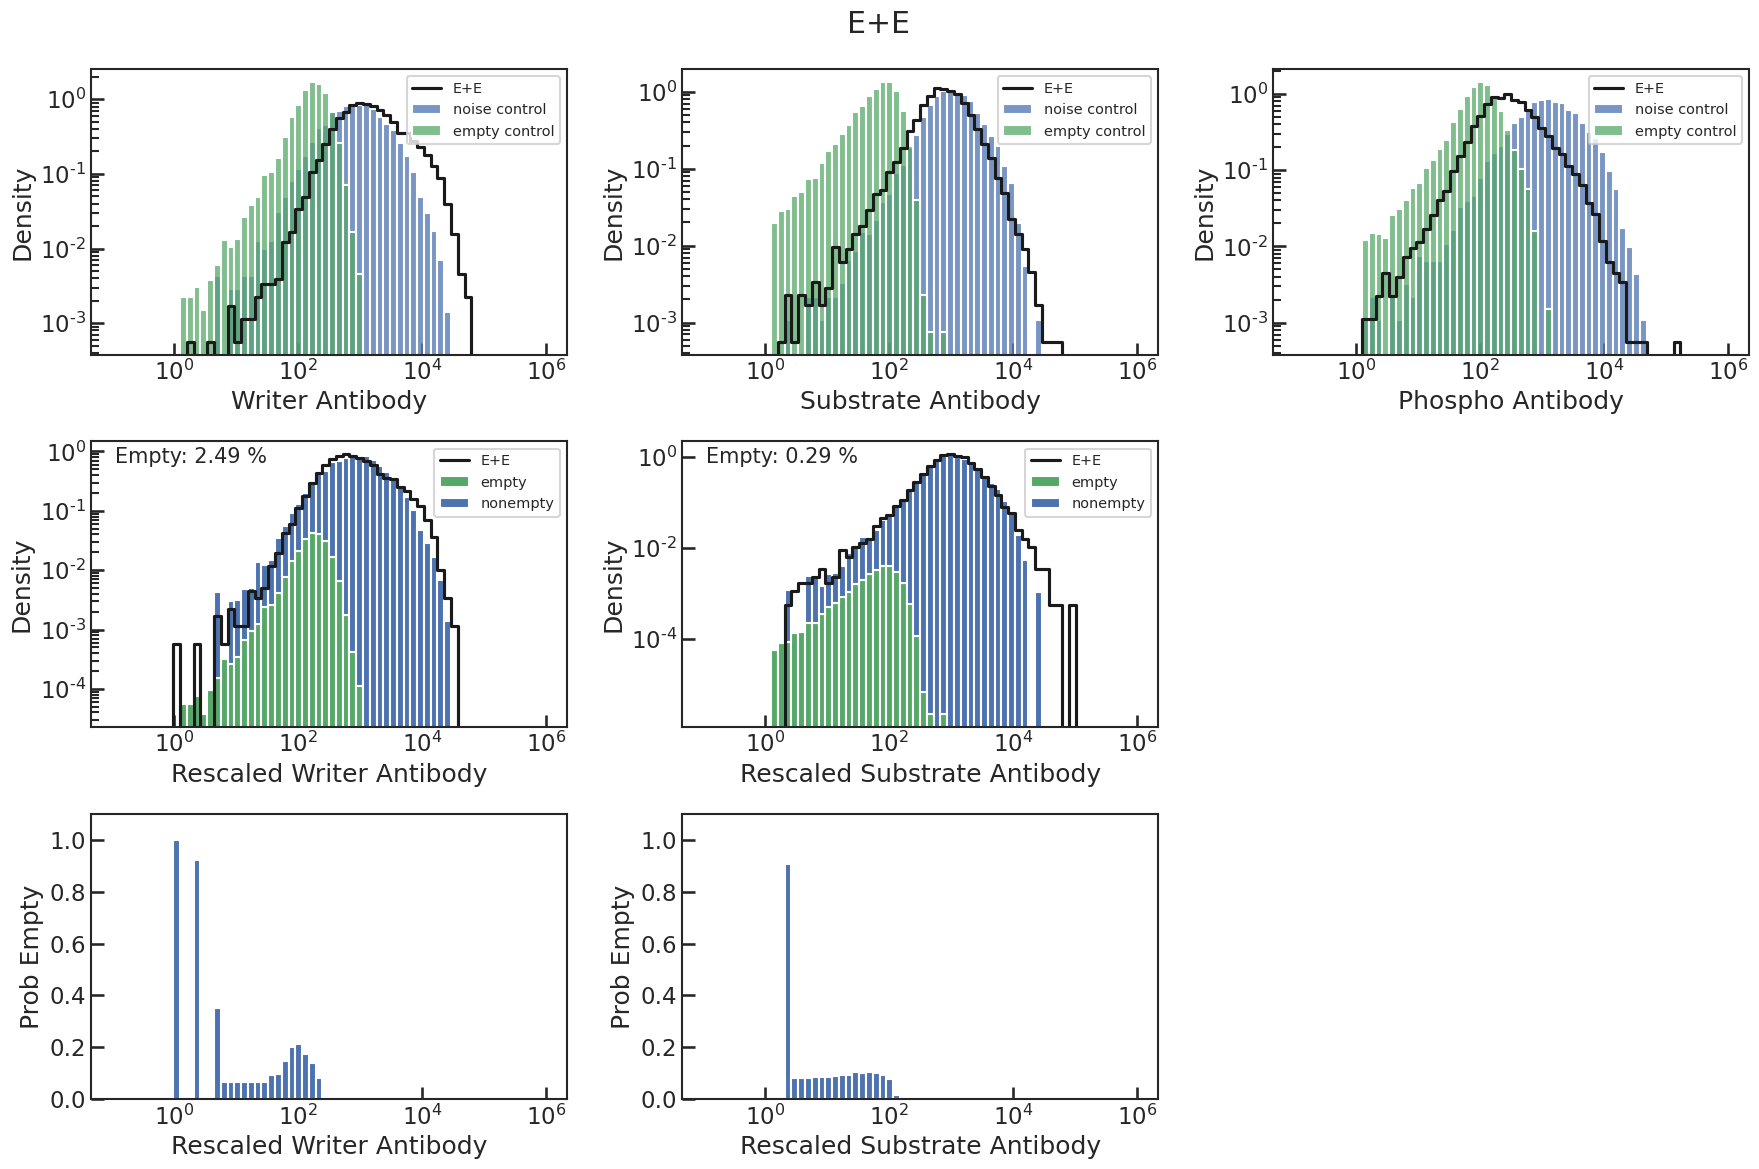

2 0.4236343866698006 [0.05424365 0.04424365] 0
4 0.41345772014671345 [0.03443946 0.04424365] 0
6 0.3539159112791153 [0.17064371 0.25609049] 0
7 0.27402761341493787 [0.04668358 0.88213036] 0
8 0.2142803449158438 [0.11302377 0.88213036] 0
9 0.15595326554005937 [0.11302377 0.49107146] 0
12 0.06784217345212137 [0.0376198  0.49107146] 0
19 0.029286185824740074 [0.02187711 0.53462976] 0
180 0.02838268496515184 [0.02649089 0.53462976] 0
218 0.024945771331548572 [0.01536513 0.51412027] 0
340 0.02361464640246491 [0.01375839 0.51412027] 0
688 0.023575330137577843 [0.01395733 0.51412027] 0
2327 0.02215703353905707 [0.00750436 0.50734658] 0
2472 0.022049619983854907 [0.00804687 0.50734658] 0
2493 0.02125037151998002 [0.00804687 0.50559556] 0
2520 0.021166062721736267 [0.00633079 0.50559556] 0
2578 0.021052386605702245 [0.00781054 0.50553981] 0
2733 0.021021889531431692 [0.00781054 0.50621756] 0
2865 0.02102188953143158 [0.00781054 0.50583984] 0
3028 0.02101651063166543 [0.00790161 0.50583984] 0
38

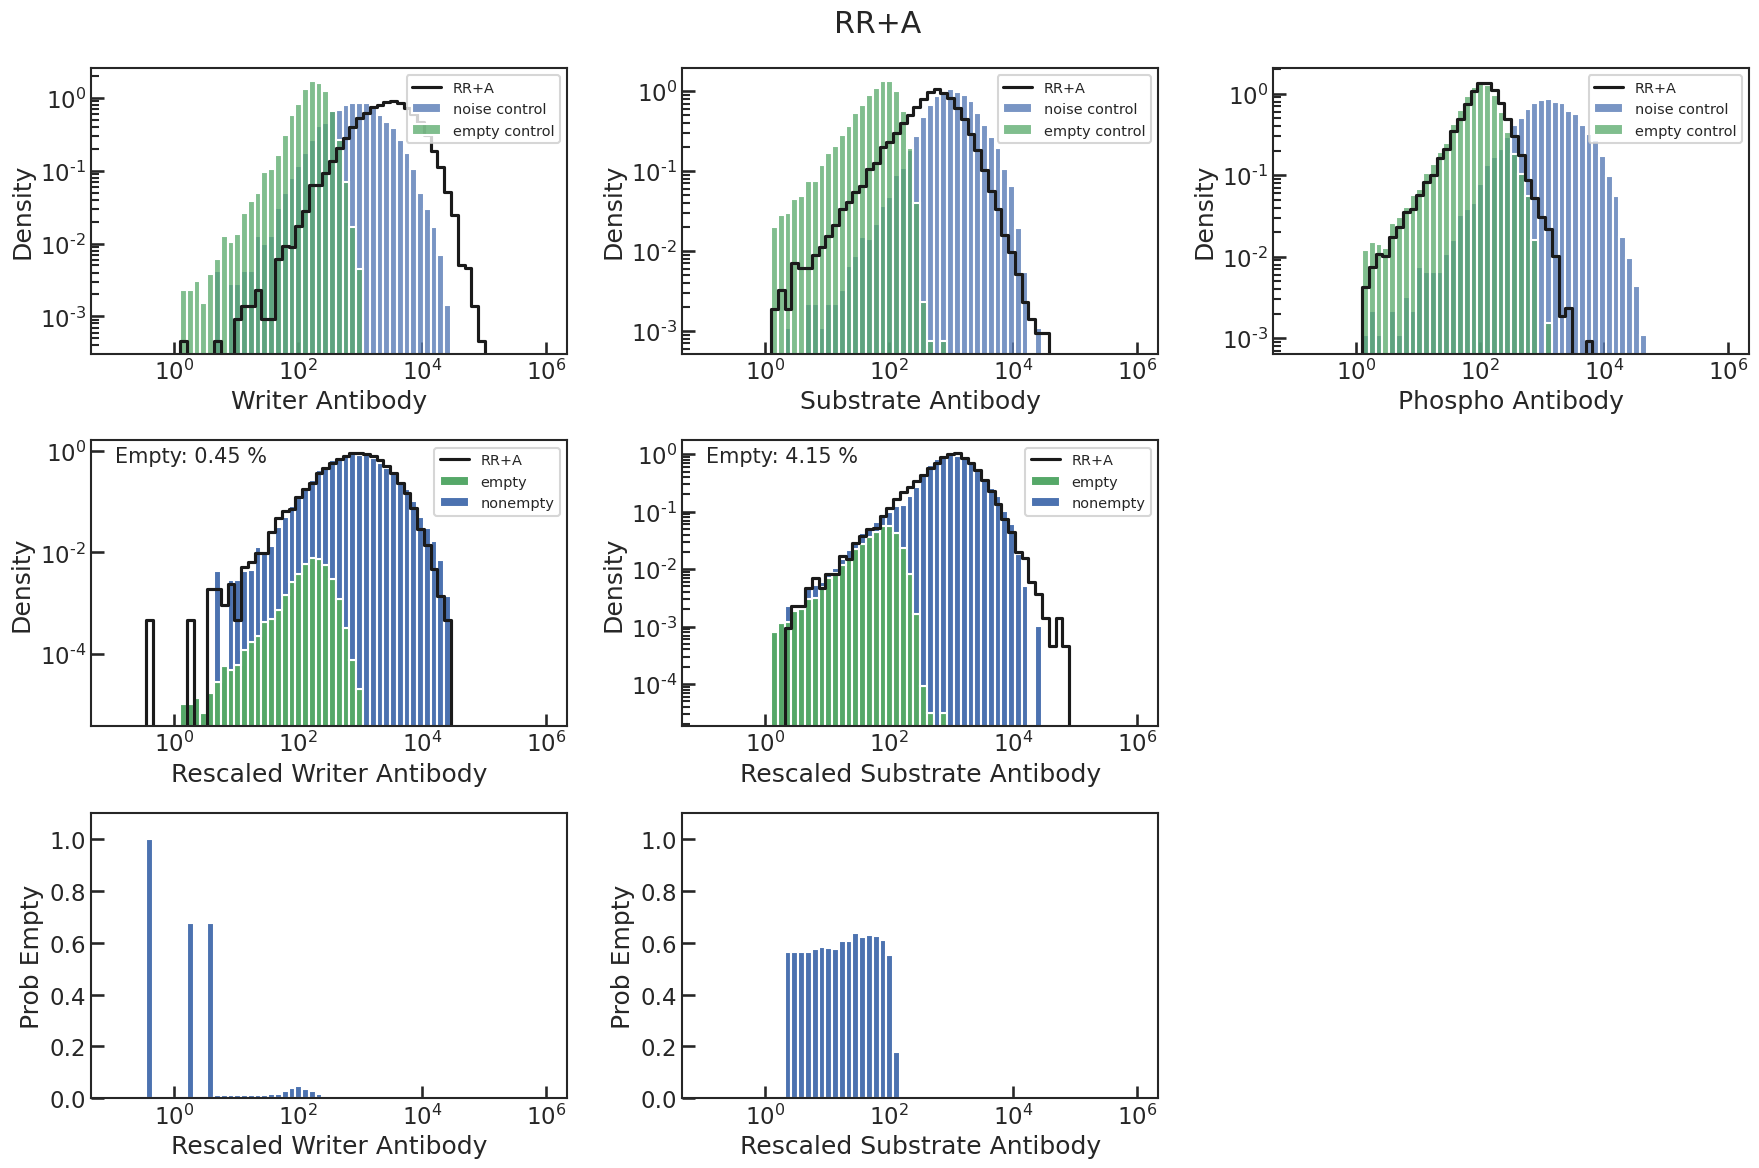

dataset zipper kinase model  WT_empty_frac  WT_anti_scale  ST_empty_frac  \
0     E+E    E+E     wt  push       0.024878       0.249342       0.002935   
1    RR+A   RR+A     wt  push       0.004531       0.501207       0.041483   

   ST_anti_scale  
0      -0.125425  
1      -0.272516

In [11]:
binrange = (-1, 6)

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()
    
    fig = plt.figure(figsize=(18, 12))
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(3, 3, 1)
    
    sns.histplot(df_tmp['WT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ################################################################
    
    
    (writer_empty_frac, writer_anti_scale) = noise.calc_mixture(df_tmp['WT_anti_exp'], 
                                                                empty_writer_noise, writer_noise)

    
    df_info.loc[index, 'WT_empty_frac'] = writer_empty_frac
    df_info.loc[index, 'WT_anti_scale'] = writer_anti_scale
    
        
    df.loc[df_tmp.index, 'WT_anti_rescaled'] = df_tmp['WT_anti_exp'] / 10**writer_anti_scale
        
        
    ax = fig.add_subplot(3, 3, 4, sharex=ax)
            
    
    
    sns.histplot(df.loc[df_tmp.index, 'WT_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*writer_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'WT_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    ax = fig.add_subplot(3, 3, 7, sharex=ax)
    
    df_tmp = df_tmp.copy()
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'WT_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'WT_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Writer Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    
    
    ax = fig.add_subplot(3, 3, 2)
        
    sns.histplot(df_tmp['ST_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    
    ################################################################
    
    (substrate_empty_frac, substrate_anti_scale) = noise.calc_mixture(df_tmp['ST_anti_exp'], 
                                                                empty_substrate_noise, substrate_noise)

        
    df_info.loc[index, 'ST_empty_frac'] = substrate_empty_frac
    df_info.loc[index, 'ST_anti_scale'] = substrate_anti_scale
        
    ax = fig.add_subplot(3, 3, 5, sharex=ax)
            
    df.loc[df_tmp.index, 'ST_anti_rescaled'] = df_tmp['ST_anti_exp'] / 10**substrate_anti_scale
    
    sns.histplot(df.loc[df_tmp.index, 'ST_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
      
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*substrate_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'ST_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    
    ax = fig.add_subplot(3, 3, 8, sharex=ax)
    
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'ST_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'ST_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Substrate Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    ax = fig.add_subplot(3, 3, 3)
    
    sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    
display(df_info)


In [33]:

zero = 0.0

for dataset, group in df.groupby("dataset"): 
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'WT_anti_bin'] = anti_bin
#     df.loc[group.index, 'WT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'WT_conc_infer'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'ST_anti_bin'] = anti_bin
#     df.loc[group.index, 'ST_GFP_bin'] = GFP_bin
    df.loc[group.index, 'ST_conc_infer'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    
    GFP_infer, anti_bin, GFP_bin = combined_phospho_noise.anti_to_GFP(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'SpT_anti_bin'] = anti_bin
#     df.loc[group.index, 'SpT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'SpT_conc_infer'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df.loc[group.index, 'Sp_frac_GFP_infer'] = df.loc[group.index, 'SpT_GFP_infer'] / df.loc[group.index, 'ST_GFP_infer']
    df.loc[group.index, 'Sp_frac_conc_infer'] = df.loc[group.index, 'SpT_conc_infer'] / df.loc[group.index, 'ST_conc_infer']
    
    
    df.loc[group.index, 'total_prob_empty'] = 1.0  - (1-df.loc[group.index, 'ST_prob_empty'])*(1-df.loc[group.index, 'WT_prob_empty'])
    
    
print(len(df))
print(len(df.dropna()))

35841
35798


WT_anti_exp   ST_anti_exp   SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                      
E+E     470     1447.981201  25963.341797     603.884277          0.023259   
        973    15569.405273  23241.884766    5672.762695          0.244075   
        1152       4.233475   1716.994141      51.646057          0.030079   
        3083    1606.739502  22507.095703     477.124023          0.021199   
        3249   53175.750000   2442.505615    2390.561035          0.978733   
        3362   33856.992188  19926.740234   19789.898438          0.993133   
        5532     601.023193  34564.945312     228.305176          0.006605   
        6945   17118.806641  21112.867188   22219.679688          1.052424   
        7201   20222.035156  25233.501953    9077.573242          0.359743   
        8188       7.909042    107.577515      58.228027          0.541266   
        8636    2221.611328  61435.937500    3406.216797          0.055443   
        8721    2406.869385      1.699152     112.022156         65.928272   
        10196  56643.859375   1187.270020    1826.527466          1.538426   
        10475      1.819967    144.571762     115.262726          0.797270   
        11127  32440.445312  40378.023438  146907.421875          3.638301   
        11339  12546.391602  20549.167969    4155.813477          0.202238   
        13086   1292.326782  22574.212891     470.123779          0.020826   
        14048  48983.800781   1354.665894    1735.056152          1.280800   
        14528  48711.523438   5104.098633   12003.803711          2.351797   
        14564  29542.138672  14651.375977   47858.167969          3.266462   
        15047  13107.743164  21201.914062   11006.217773          0.519114   
        15737  11870.414062  22496.205078    9210.739258          0.409435   
RR+A    650        5.169678    159.634521      65.069946          0.407618   
        873    14287.659180  13726.181641    1244.380737          0.090657   
        1769   11292.632812  27197.671875     367.915283          0.013527   
        2084    9939.987305  16274.576172     679.544922          0.041755   
        3010    3175.199951  13066.844727     729.479004          0.055827   
        3849      13.365425    202.374557     127.010071          0.627599   
        3978   20512.681641  37429.113281      72.184082          0.001929   
        5297    3466.614014  14256.462891     302.607910          0.021226   
        5865    2472.151855  18193.087891      97.370117          0.005352   
        10294  85278.843750   3305.764404     688.048584          0.208136   
        11470  24016.962891  14138.311523    1254.129883          0.088704   
        12914   2182.821777  27571.658203     400.685547          0.014533   
        13241     11.603683    149.695450     138.227478          0.923391   
        13869   5723.737793  14640.954102     493.864746          0.033732   
        14141      1.267920   1475.036377      93.643890          0.063486   
        14968     12.090755    242.111038      29.509247          0.121883   
        14994  19400.943359  18982.138672    5772.825195          0.304119   
        15317   8434.956055  20328.437500    1748.737305          0.086024   
        15494   6329.875488  14687.336914     250.763184          0.017073   
        17884     11.341026    310.896484      60.213806          0.193678   
        19399  16272.580078  31130.406250    2843.011719          0.091326   

               WT_anti_rescaled  WT_prob_empty  ST_anti_rescaled  \
dataset                                                            
E+E     470          815.493366       0.000000      34656.605850   
        973         8768.585328       0.000000      31023.927731   
        1152           2.384265       0.921462       2291.892533   
        3083         904.904984       0.000000      30043.110425   
        3249       29948.228148       0.000000       3260.325849   
        3362       19068.0324

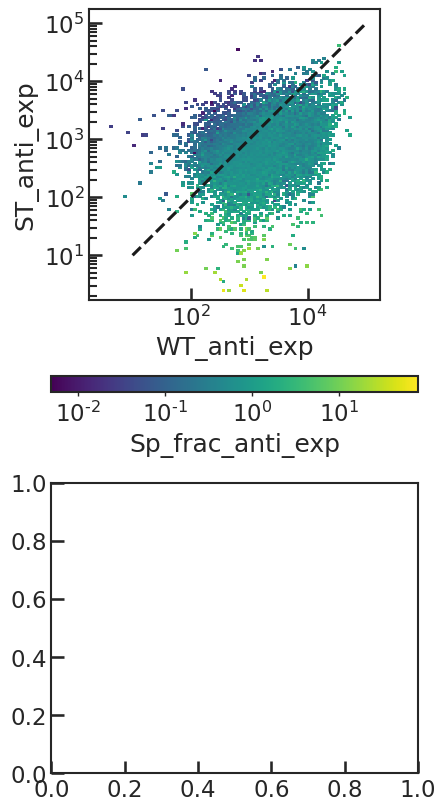

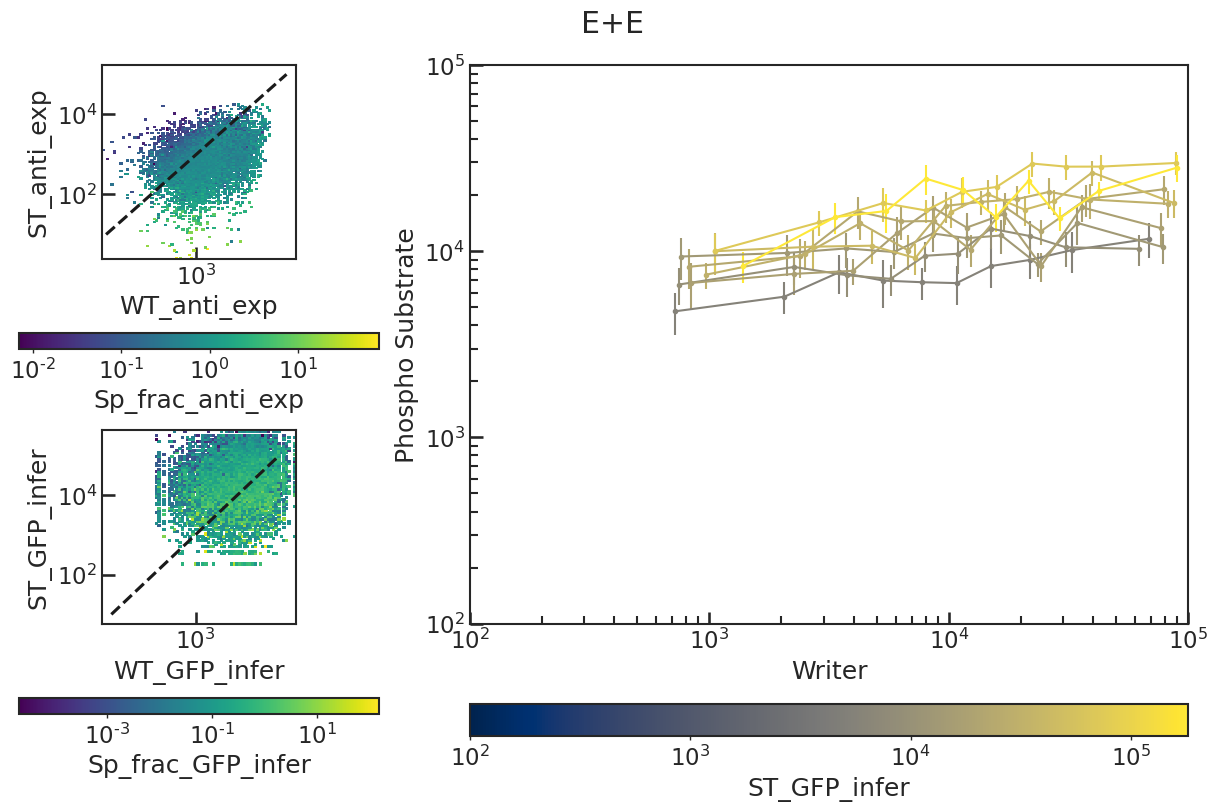

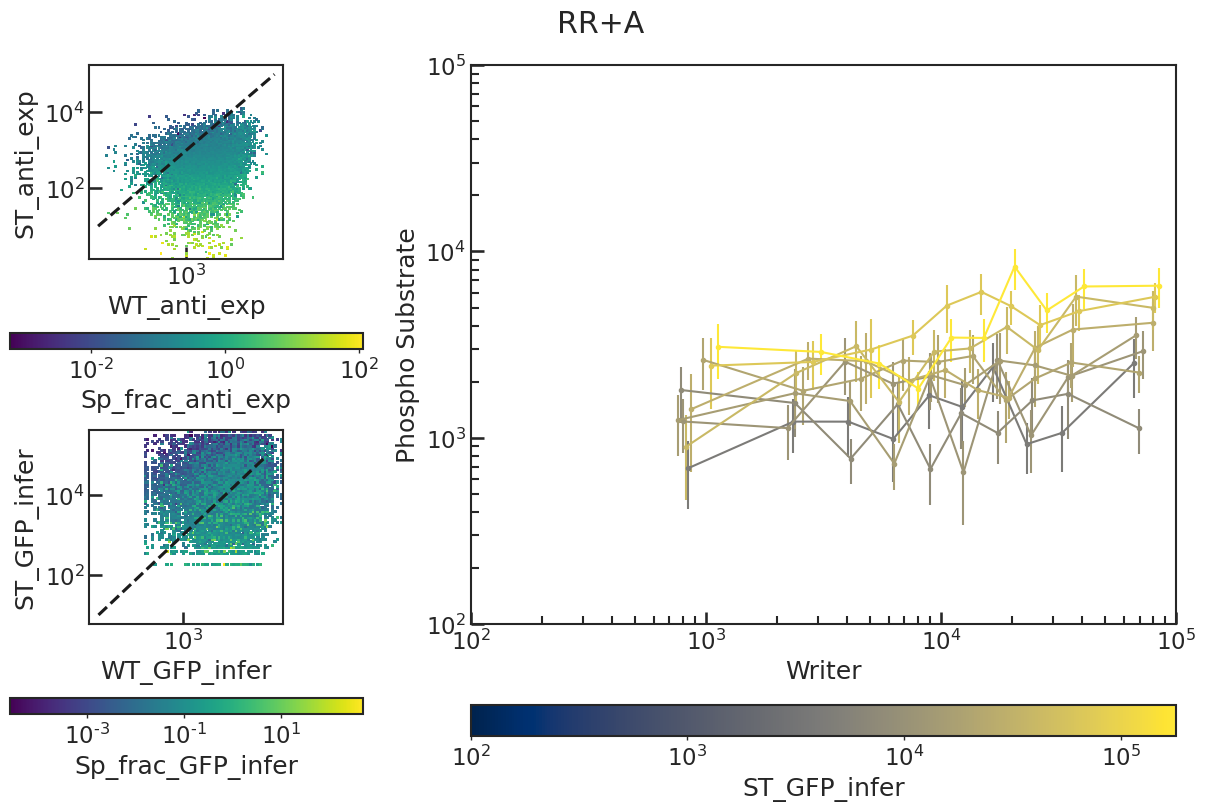

In [35]:



for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.dropna().query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp')

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_infer')

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

In [36]:
res, param_dict, param_labels = fit.fit_push(df_info, df, empty_phospho_noise)

['$\\log_{10}(v_{bg}^p)$', 'wt: $\\log_{10}(v_{WS}^p)$', 'EE_L: $\\log_{10}(\\alpha_{WS})$', 'EE_E: $\\log_{10}(\\alpha_{WS})$', 'RR: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$', '375: $\\log_{10}(v_{WS}^p)$', 'generic: $\\log_{10}(\\alpha_{WS})$', '419: $\\log_{10}(v_{WS}^p)$', '421: $\\log_{10}(v_{WS}^p)$']
{'L_250': [0, 1, 2], 'E_250': [0, 1, 3], 'RR_250': [0, 1, 4], 'S+E_250': [0, 1, 5], '375': [0, 6, 7], '419': [0, 8, 7], '421_1000': [0, 9, 7]}
[-2.0, 0.0, 4.0, 4.0, 4.0, 4.0, 0.0, 4.0, 0.0, 0.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 3.754849949130052
3.018378798656702 1.0201000000000015e-06 [-2.00885263  0.55492245  3.76563181  3.86621627  4.10598982  4.00749251
 -0.43113407  4.33913231 -0.02269426 -0.57145765]
2.7098527430837316 3.0735929052739017e-06 [-2.10230085  0.34973975  3.55820111  3.77182231  4.37588231  4.11727215
 -0.84691188  4.6809177

dataset   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0     L_250     EE_L     wt  push       0.001320       0.336913   
1     E_250     EE_E     wt  push       0.003690       0.278620   
2    RR_250       RR     wt  push       0.000399       0.248533   
3   S+E_250      S+E     wt  push       0.002518       0.192824   
4       375  generic    375  push       0.000621       0.426397   
5       419  generic    419  push       0.006490       0.318600   
6  421_1000  generic    421  push       0.001675       0.328734   

   ST_empty_frac  ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
0       0.003508       0.388868          0.00748            11.726074   
1       0.026181       0.273877          0.00748            11.726074   
2       0.029363       0.282584          0.00748            11.726074   
3       0.004982       0.207894          0.00748            11.726074   
4       0.001565       0.348545          0.00748             0.048100   
5       0.032397       0.346711          0.00748             0.550308   
6       0.000031       0.411817          0.00748             0.000014   

   kinase_bind_affin  
0       5.636826e-01  
1       1.265080e+04  
2       3.468099e+06  
3       4.169527e+05  
4       9.795547e+02  
5       9.795547e+02  
6       9.795547e+02

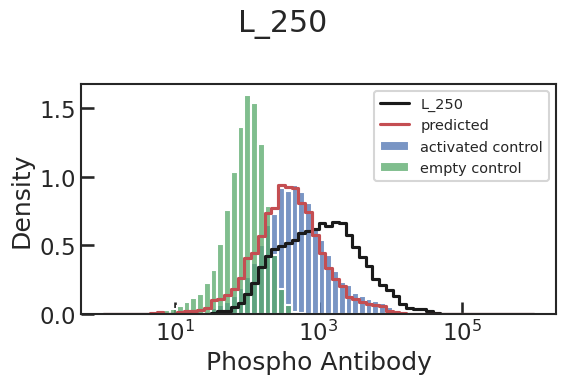

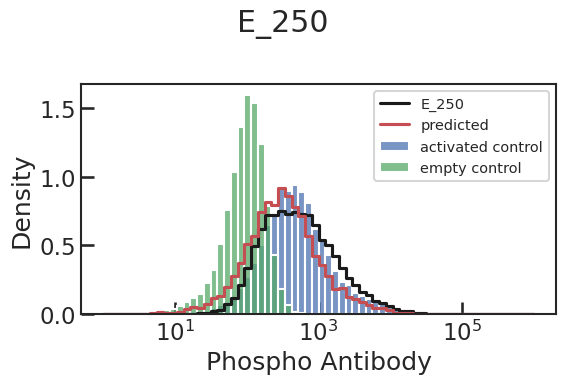

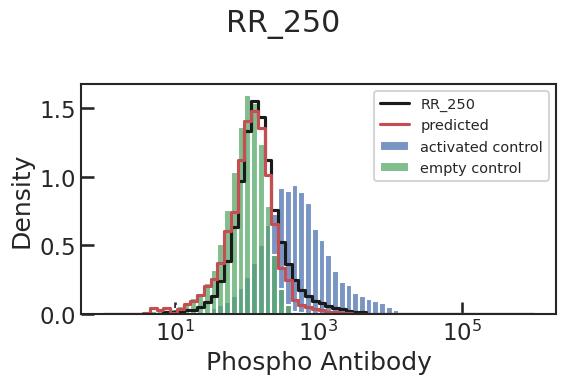

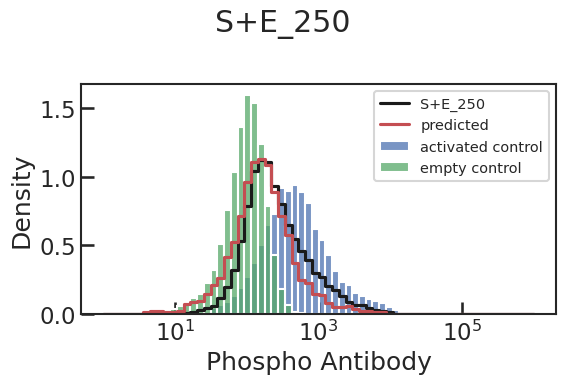

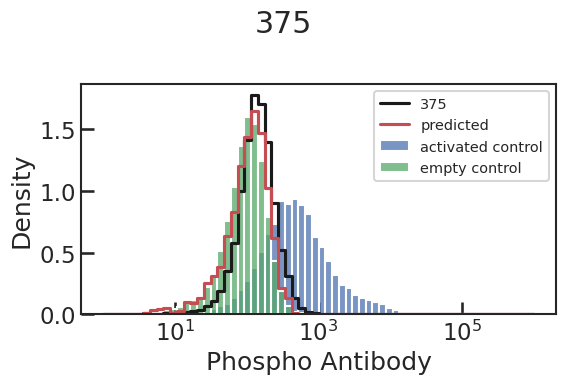

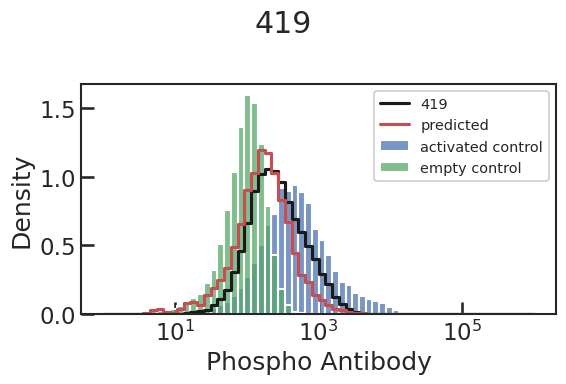

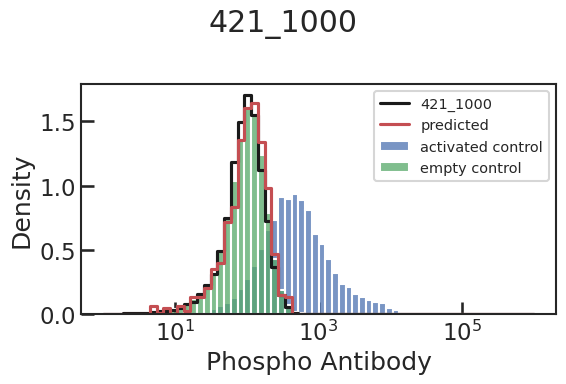

dataset   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0     L_250     EE_L     wt  push       0.001320       0.336913   
1     E_250     EE_E     wt  push       0.003690       0.278620   
2    RR_250       RR     wt  push       0.000399       0.248533   
3   S+E_250      S+E     wt  push       0.002518       0.192824   
4       375  generic    375  push       0.000621       0.426397   
5       419  generic    419  push       0.006490       0.318600   
6  421_1000  generic    421  push       0.001675       0.328734   

   ST_empty_frac  ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
0       0.003508       0.388868          0.00748            11.726074   
1       0.026181       0.273877          0.00748            11.726074   
2       0.029363       0.282584          0.00748            11.726074   
3       0.004982       0.207894          0.00748            11.726074   
4       0.001565       0.348545          0.00748             0.048100   
5       0.032397       0.346711          0.00748             0.550308   
6       0.000031       0.411817          0.00748             0.000014   

   kinase_bind_affin  
0       5.636826e-01  
1       1.265080e+04  
2       3.468099e+06  
3       4.169527e+05  
4       9.795547e+02  
5       9.795547e+02  
6       9.795547e+02

In [44]:
binrange = (0, 6)

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.dropna().query("dataset==@dataset").copy()  
    
    model_params = 10**res.x[param_dict[dataset]]
    
    df.loc[df_tmp.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df.loc[df_tmp.index, 'SpT_GFP_predict'] = df.loc[df_tmp.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
    
    df.loc[df_tmp.index, 'Sp_frac_GFP_predict'] = df.loc[df_tmp.index, 'SpT_GFP_predict'] / df_tmp['ST_GFP_infer']

    
    anti, GFP_bins, anti_bins = inverse_phospho_noise.GFP_to_anti(df.loc[df_tmp.index, 'SpT_GFP_predict'])
    
    df.loc[df_tmp.index, 'SpT_anti_predict'] = anti
    
    df.loc[df_tmp.index, 'Sp_frac_conc_predict'] = df.loc[df_tmp.index, 'SpT_conc_predict'] / df_tmp['ST_conc_infer']
    
    df.loc[df_tmp.index, 'Sp_frac_anti_predict'] = df.loc[df_tmp.index, 'SpT_anti_predict'] / df.loc[df_tmp.index, 'ST_anti_exp']
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(dataset)

    
    ax = axes
    
    sns.histplot(df.loc[df_tmp.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(df.loc[df_tmp.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    
display(df_info)
    

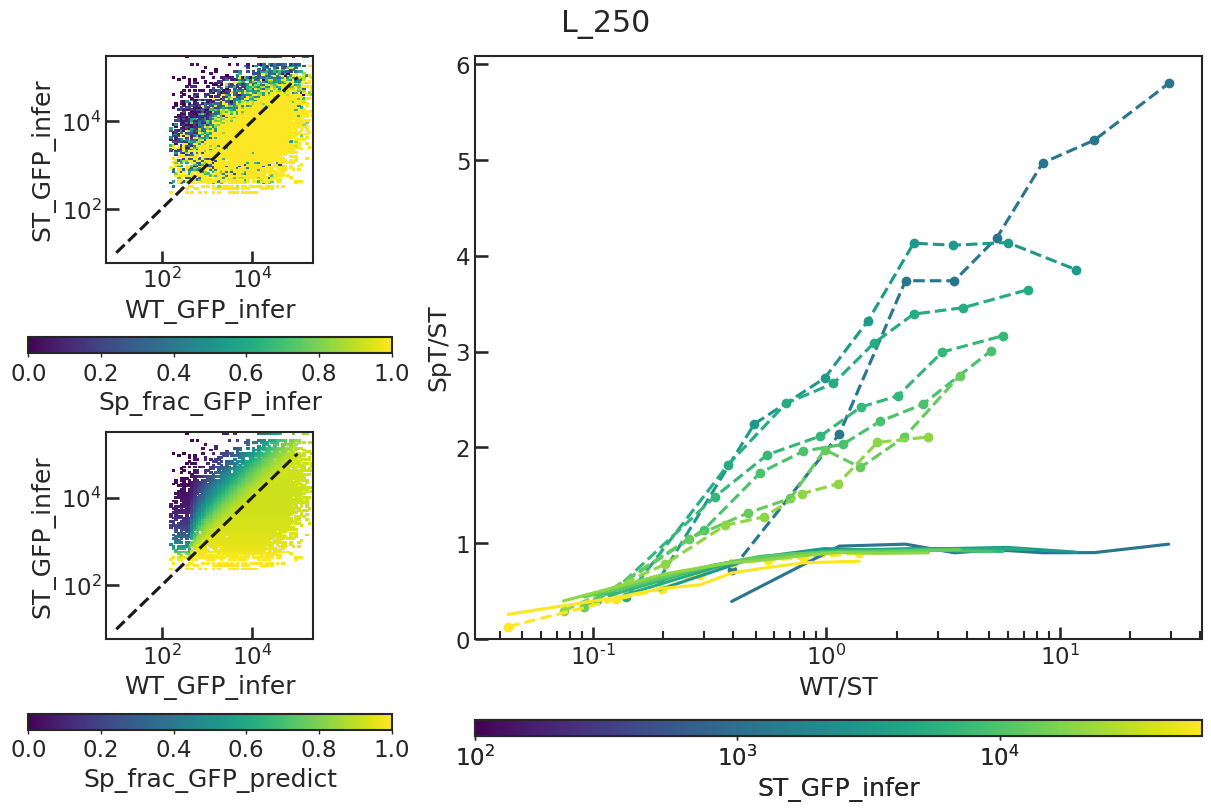

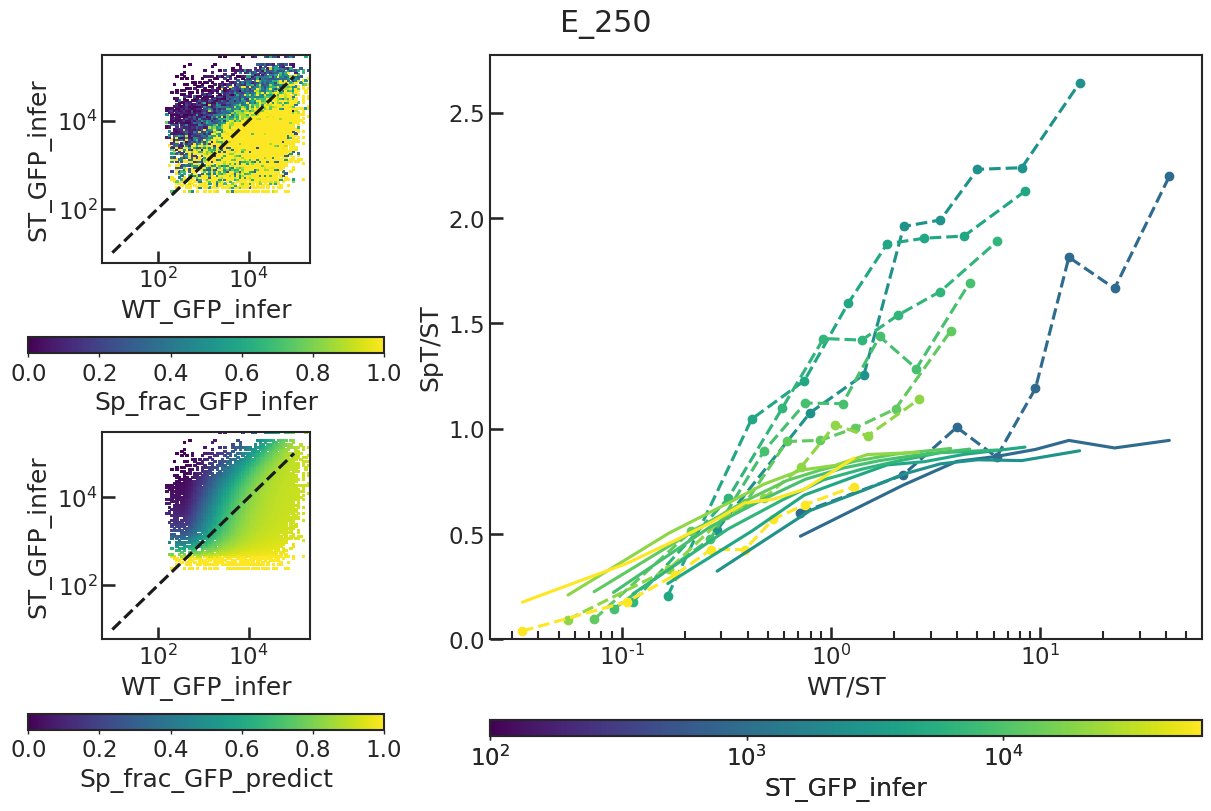

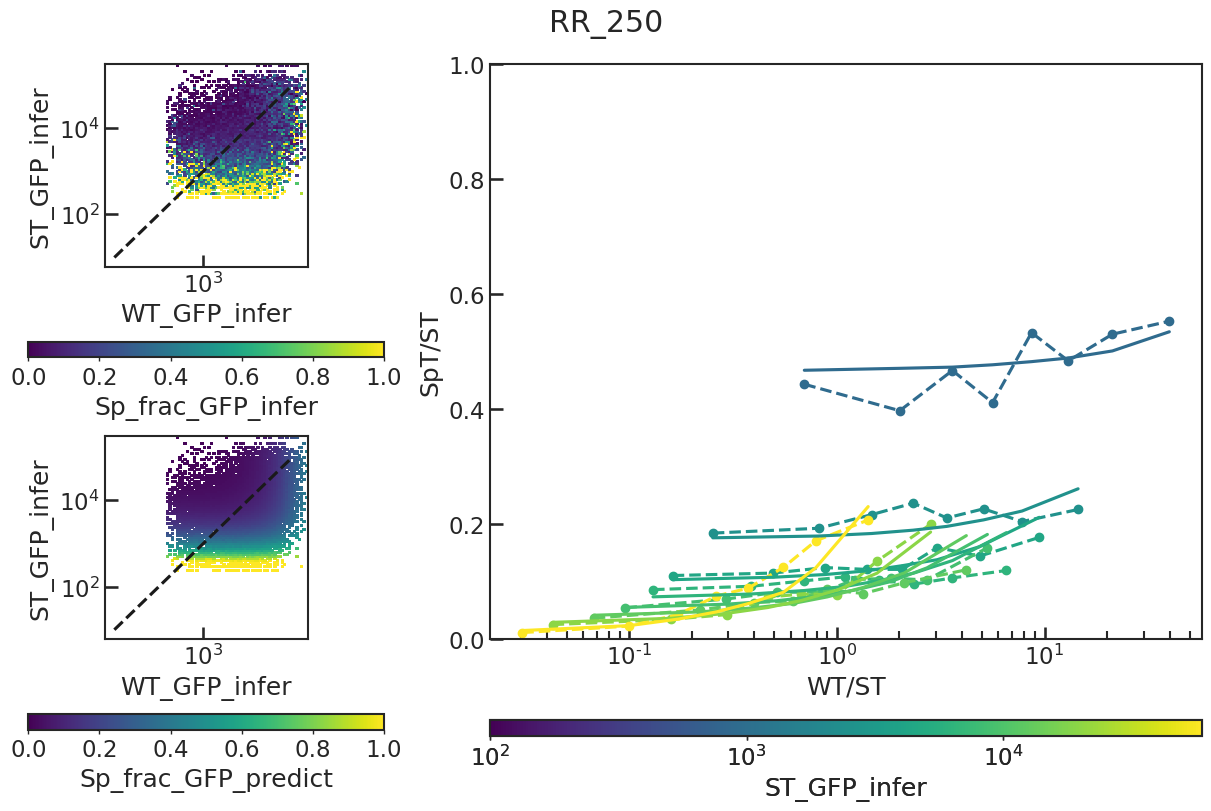

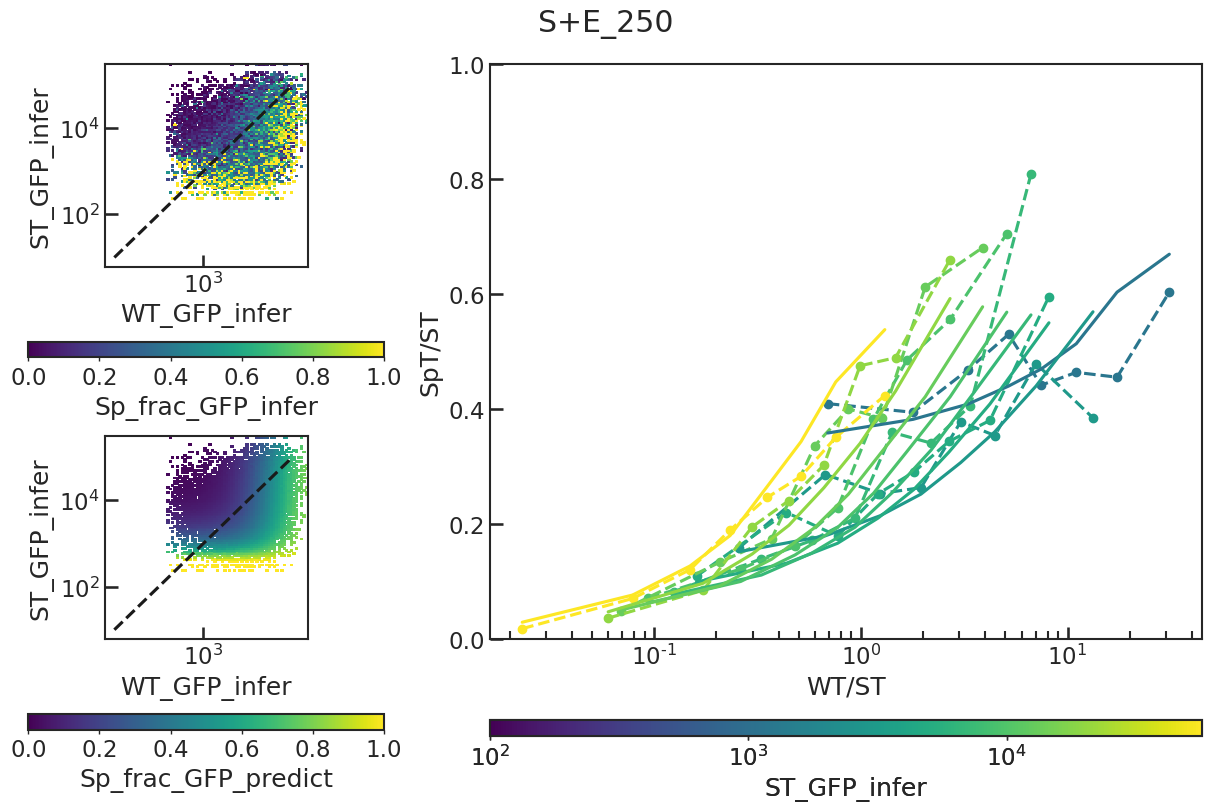

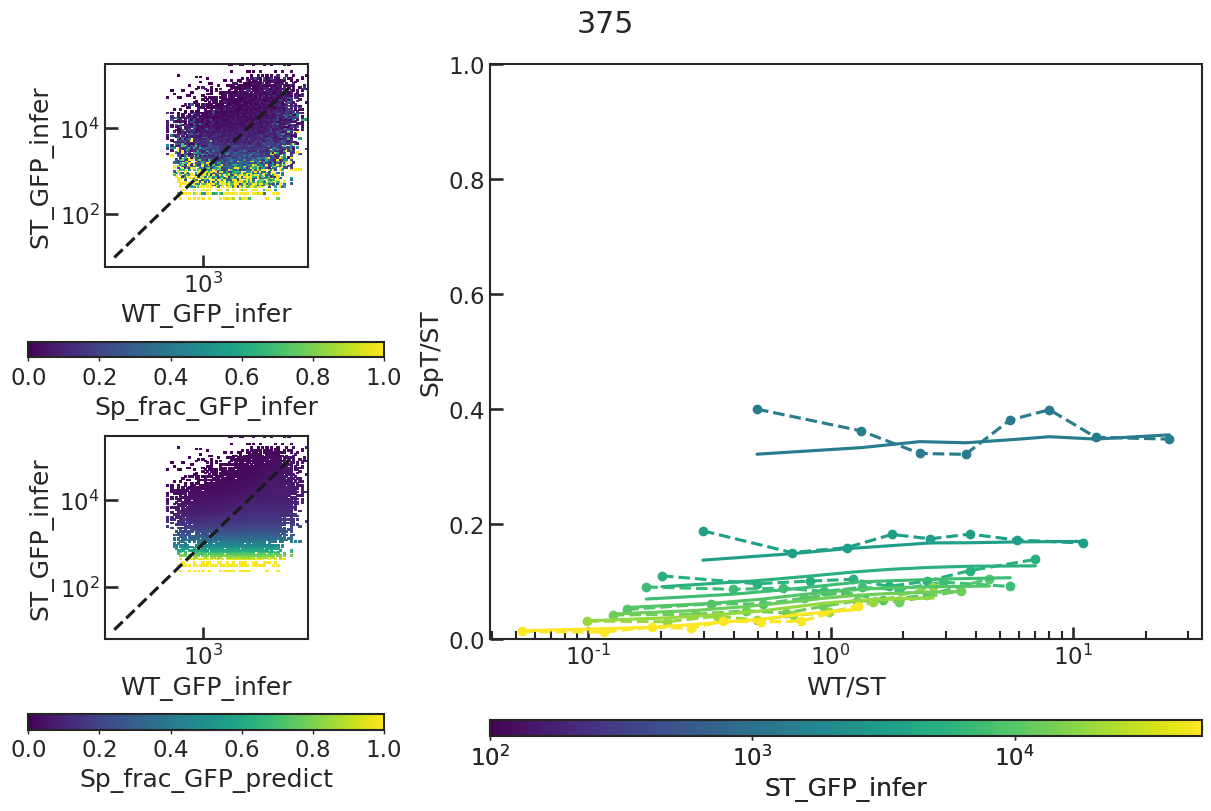

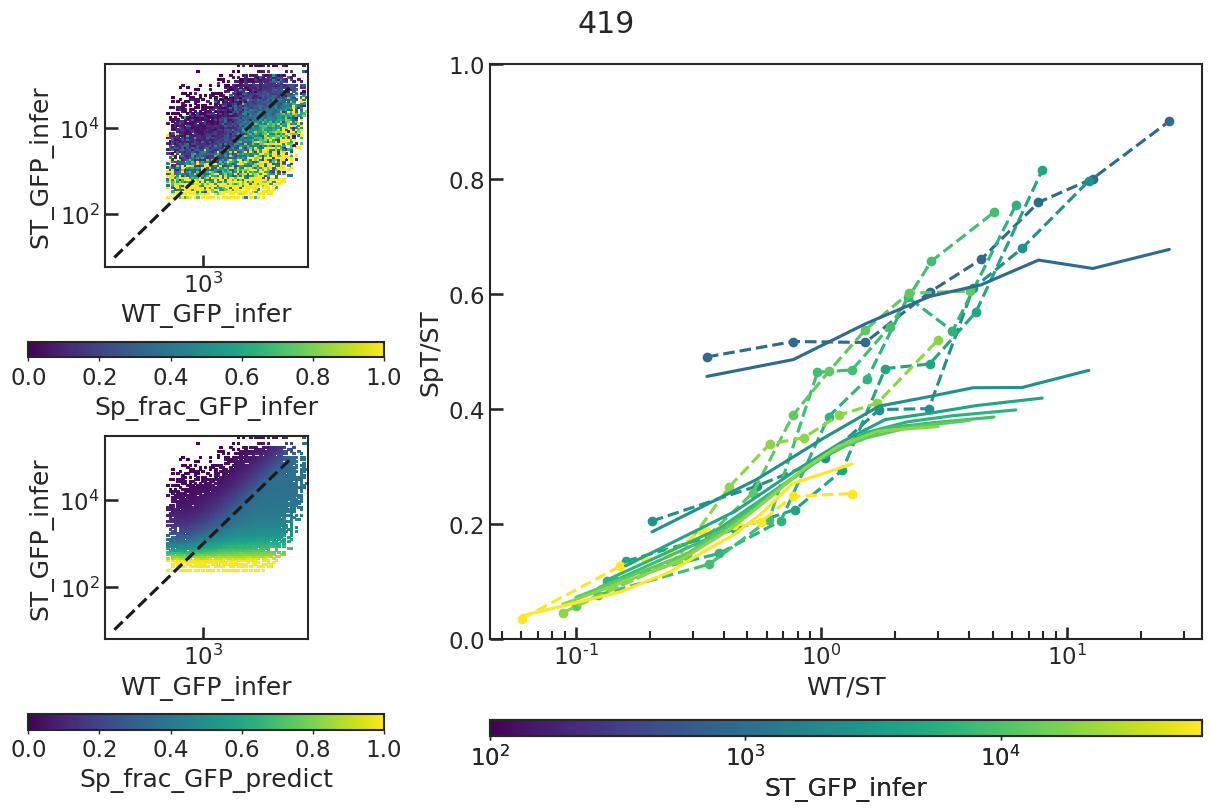

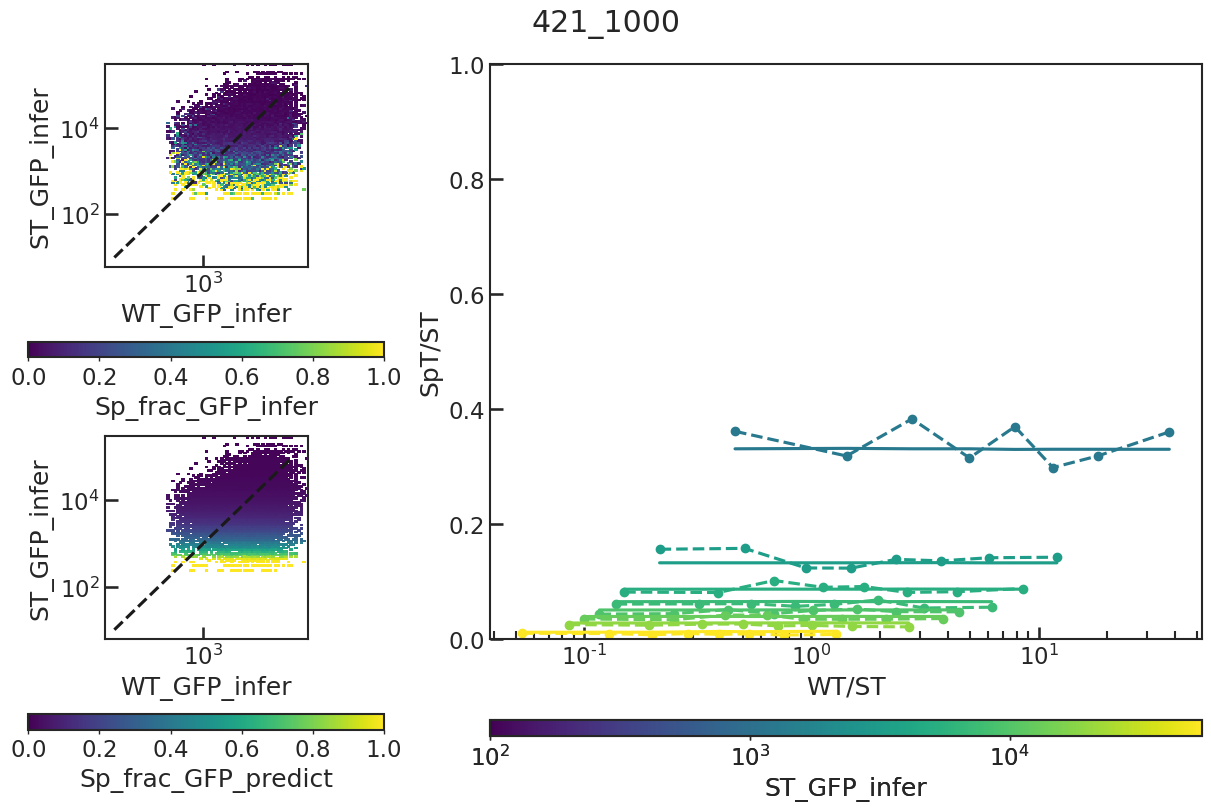

In [38]:

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.dropna().query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_infer',
                     vmax=1.0)

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_predict',
                     vmax=1.0)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer',
                                fmt='o--')

    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_predict',
                                fmt='-')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

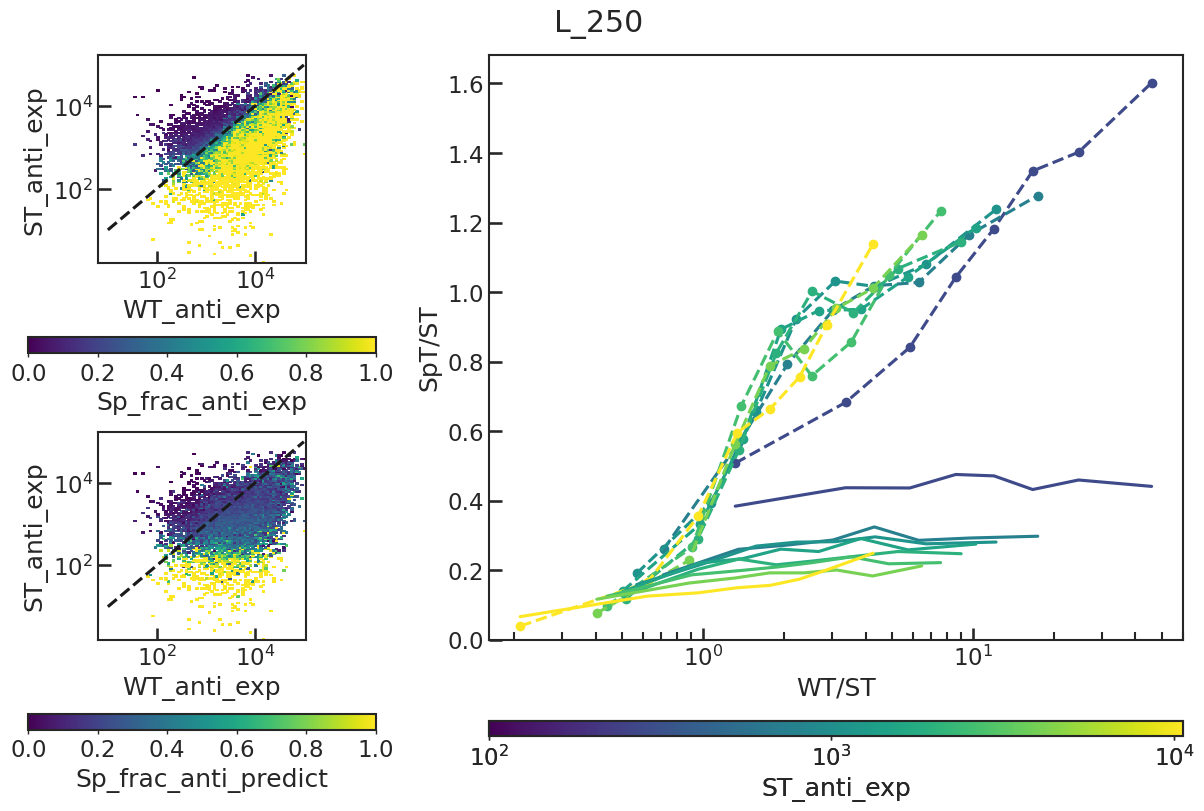

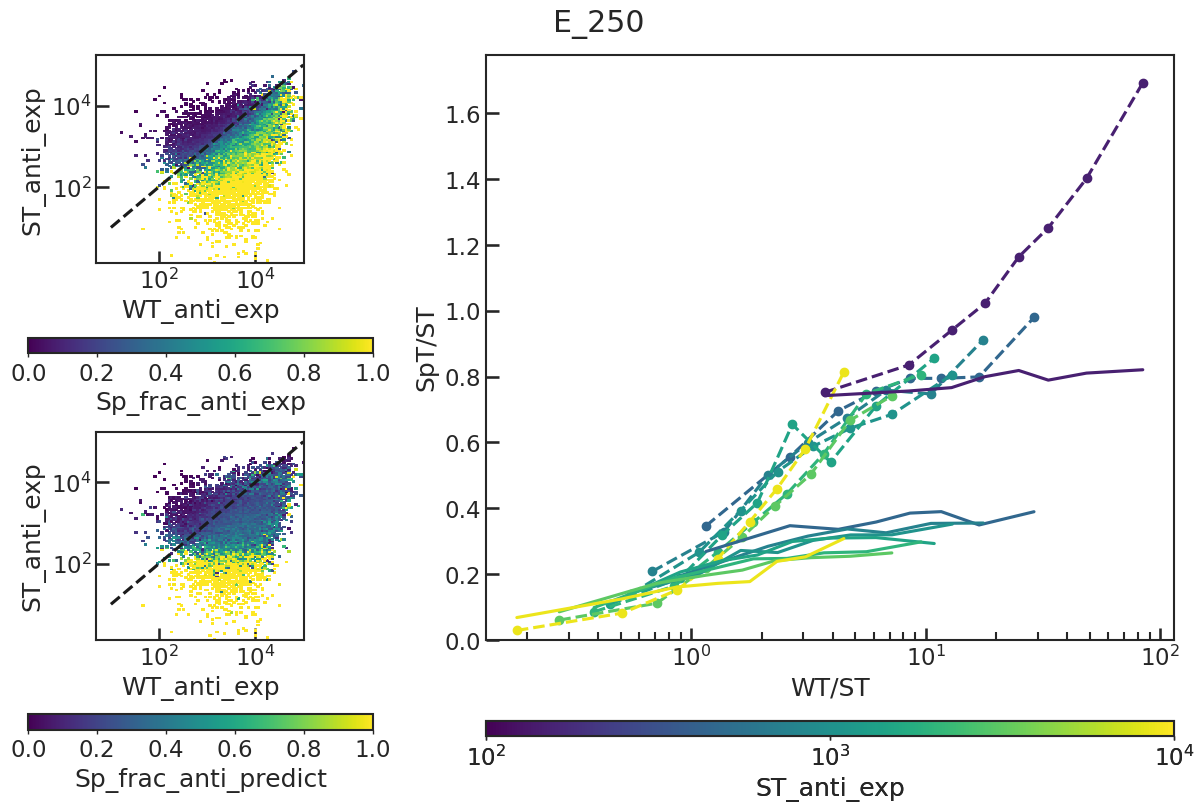

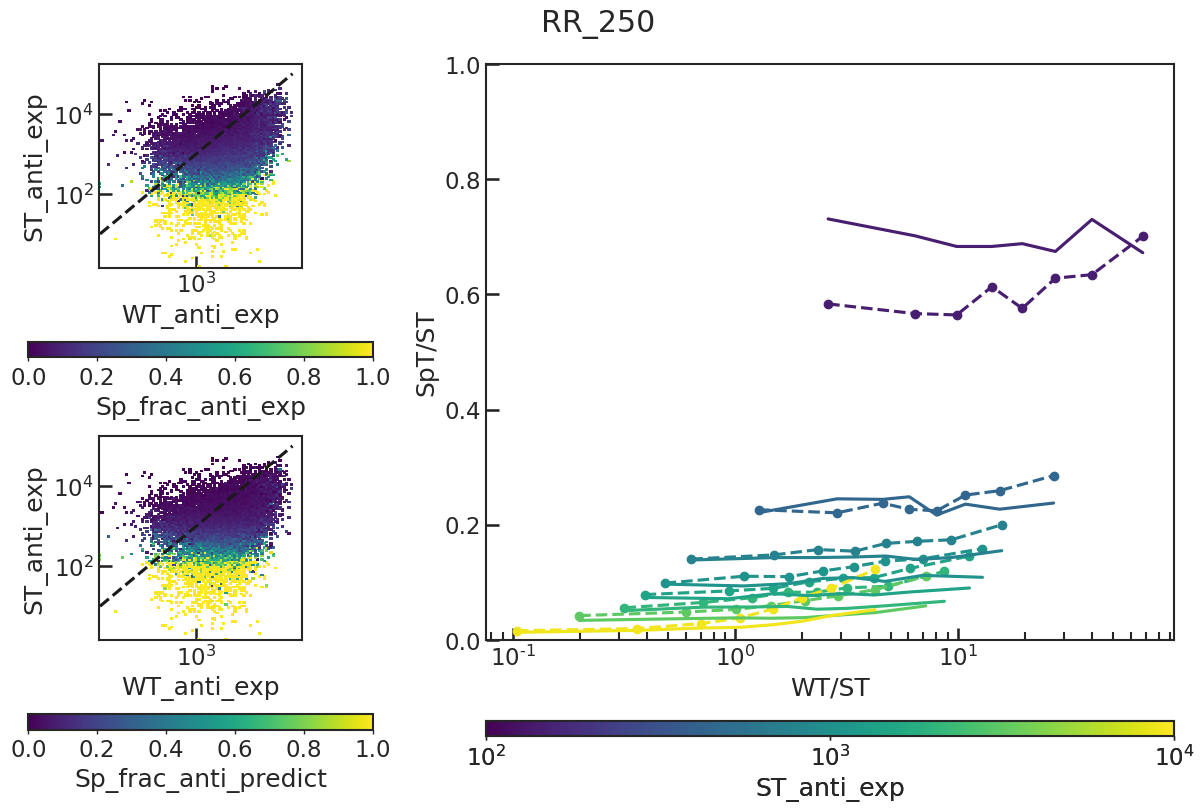

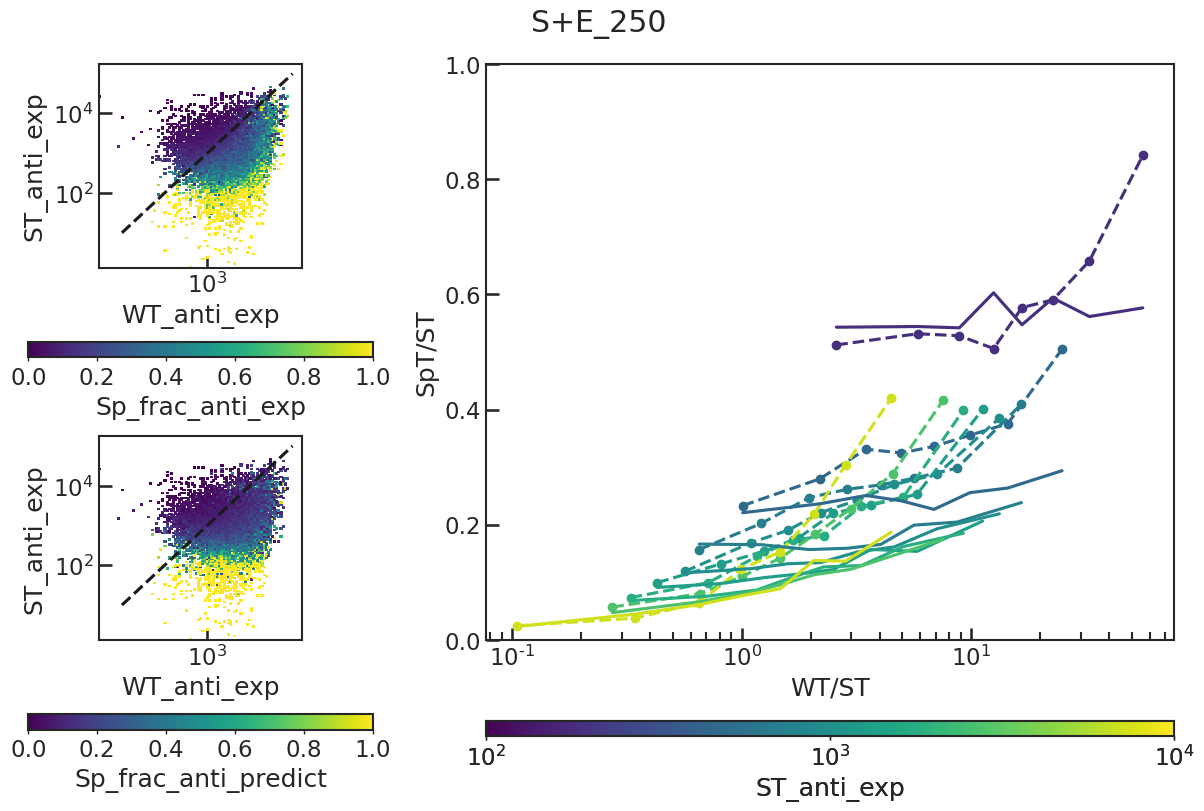

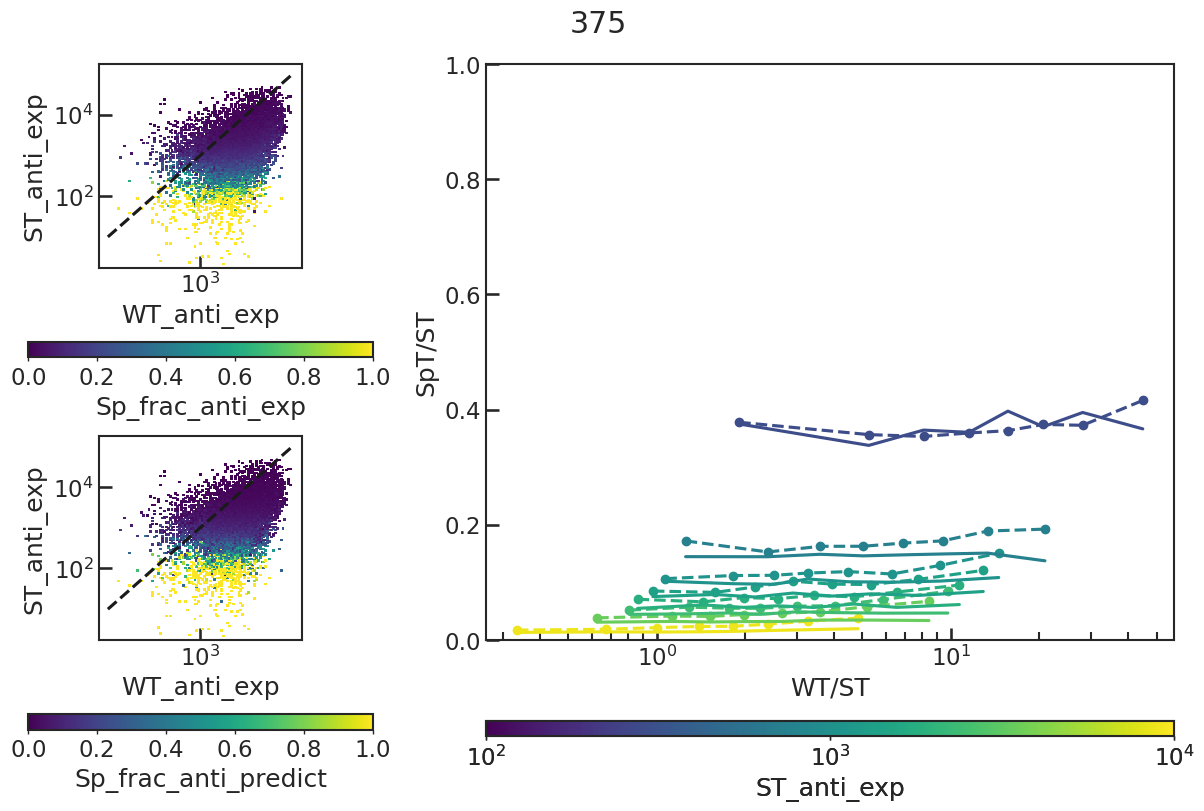

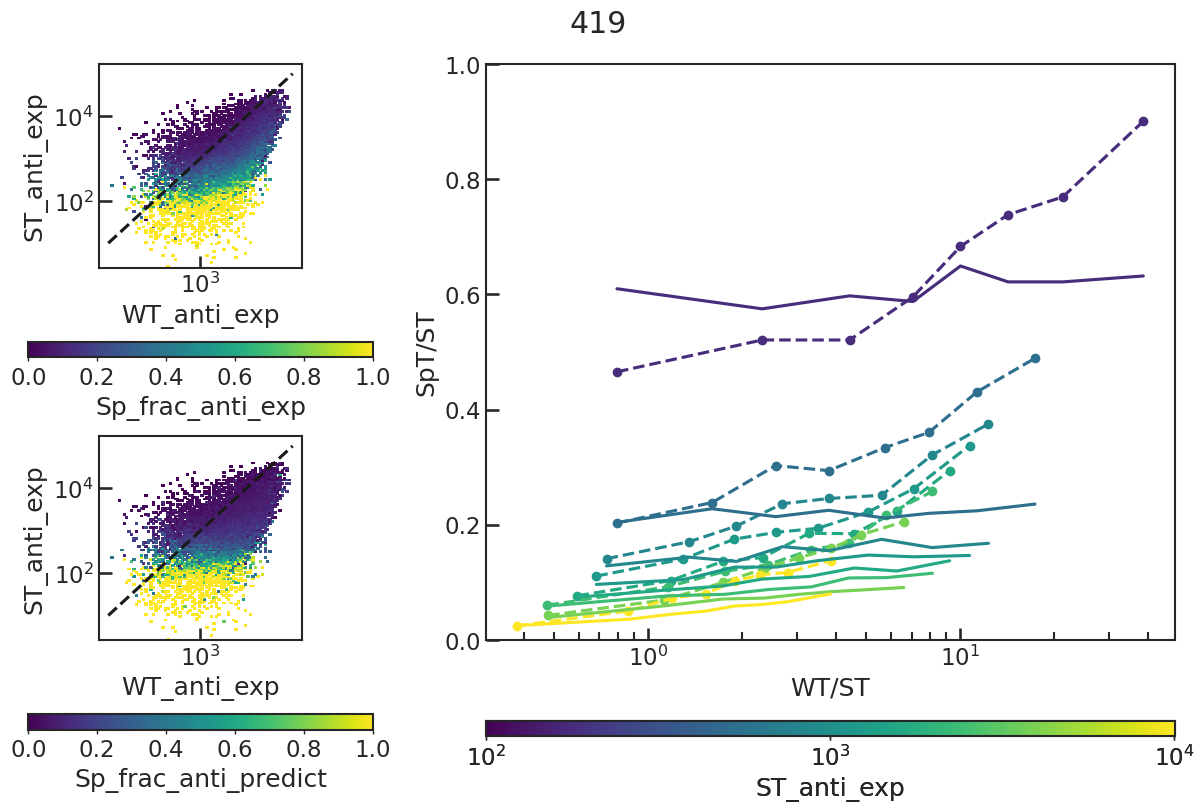

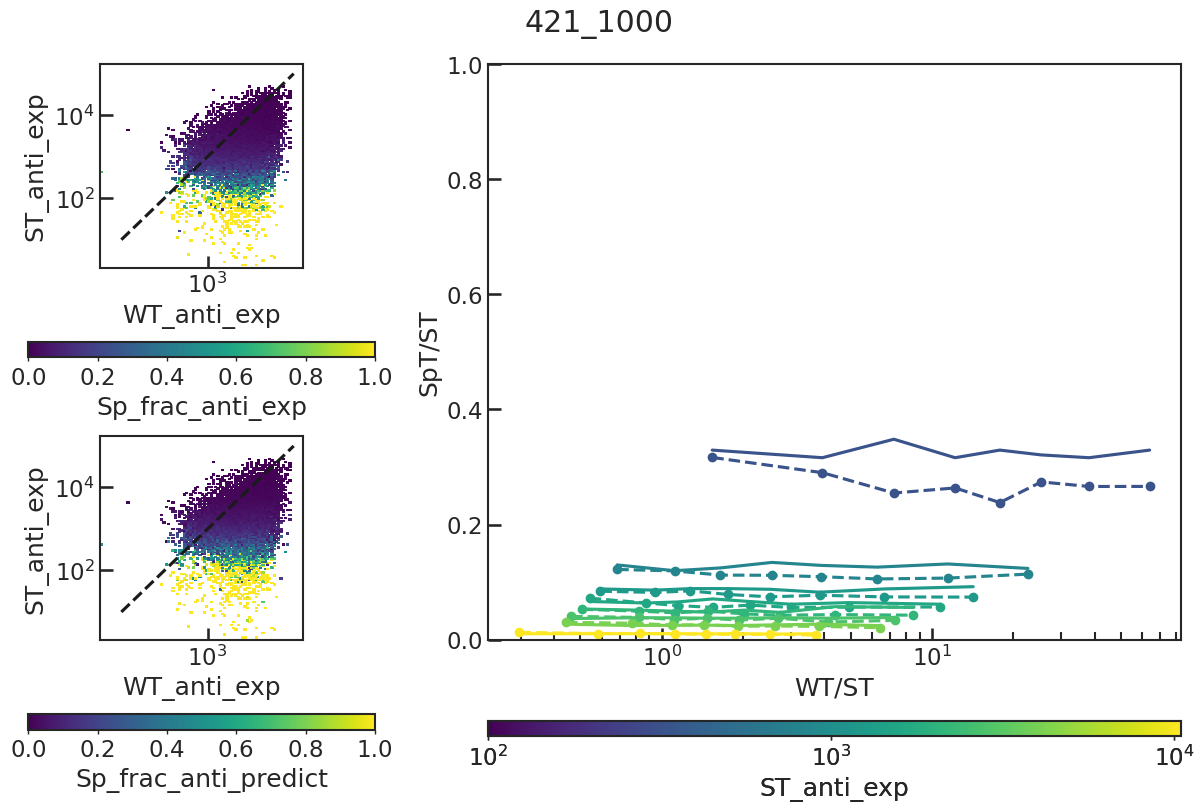

In [39]:

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.dropna().query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp',
                     vmax=1.0)

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_predict',
                     vmax=1.0)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp',
                                fmt='o--')

    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_predict',
                                fmt='-')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

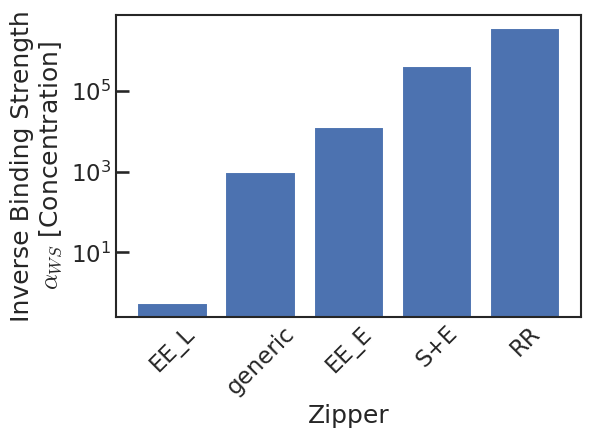

In [42]:

df_aff = df_info.groupby(['zipper']).first().sort_values('kinase_bind_affin')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_aff.index, df_aff['kinase_bind_affin'])

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

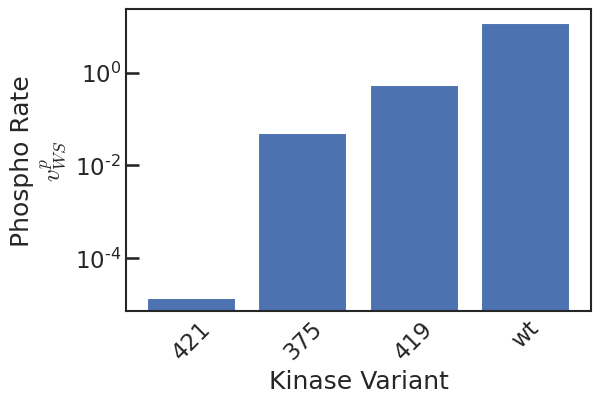

In [43]:
df_prate = df_info.groupby(['kinase']).first().sort_values('kinase_phospho_rate')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_prate.index, df_prate['kinase_phospho_rate'])

ax.set_yscale('log')
ax.set_xlabel("Kinase Variant")
ax.set_ylabel("Phospho Rate\n" + r"$v^p_{WS}$")
plt.xticks(rotation=45)

plt.show()